# Photometric Stereo

Most of the content in the notebook is borrowed from [Prof Steve Seitz](https://www.smseitz.com/) who developed in his Computer Vision class. Here is a [blog](https://www.cnblogs.com/linzzz98/articles/13622026.html) from a MSC student in our lab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


![buddhas](buddhas.jpg)

## Introduction

In this project, you will finish a 3D computer vision task, Photometric Stereso, which constructs a height field from a series of images of a Lambertian object under different illuminaiton directions. Your code will be able to calibrate the lighting directions, find the best fit normal and albedo at each pixel, then find a surface which best matches the solved normals.

## Dataset

We use the dataset psmImages, in which there are 6 objects and one chrome ball (for lighting calibration) captured under 12 lighting directions.

## 1. Calibration Lighting Directions

Before we calculate normals from images, we have to calibrate our capture setup. This includes determining the lighting intensity and direction, as well as the camera response function. For this project, we provide you with the dataset which have linearized camera response function, so you can treat pixel values as intensities. Second, all the light sources all appear to have the same brightness. You'll be solving for albedos relative to this brightness, which you can just assume is 1 in some arbitrary units. In other words, you don't need to think too much about the intensity of the light sources.

The one remaining calibration step you are going to do is calibrating lighting directions. One method of determining the direction of point light sources is to photograph a shiny chrome sphere in the same location as all the other objects. Since we know the shape of this object, we can determine the normal at any given point on its surface, and therefore we can also compute the reflection direction for the brightest spot on the surface.

Write your code below to calculate lighting directions.

In [82]:
# TODO: Load sphere images and find the brightest spot. Then calibrate the illumination direction for each image.
# The images are in the folder "psmImages/chrome". Use the mask image "chrome.mask" to locate the position of the ball in the image and threshold all other images to detect the specular highlight and find the peak pixel.
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


circle = cv2.imread('./psmImages/chrome/chrome.mask.bmp', 0)

#找到中心
maxval = np.max(circle)  #找出最大值
circleRows, circleCols = np.where(circle == maxval)
minRow = circleRows.min()
maxRow = circleRows.max()
minCol = circleCols.min()
maxCol = circleCols.max()

xc = (minCol + maxCol) / 2
yc = (minRow + maxRow) / 2
center = [xc, yc]
radius = (maxRow - minRow) / 2
# print(center, radius, (maxCol - minCol) / 2)

R = [0, 0, 1.0]
L = np.empty((12, 3))

#Calculate the lighting direction
numLights = 12
for i in range(0, numLights):
    imgFileName = './psmImages/chrome/chrome.' + str(i) + '.bmp'
    image = cv2.imread(imgFileName, 0)
    maxval = np.max(image)
    pointRows, pointCols = np.where(image == maxval)
    nSize = len(pointRows)
    px = np.sum(pointCols) / nSize
    py = np.sum(pointRows) / nSize
    Nx = px - xc
    Ny = -(py - yc)
    Nz = np.sqrt(radius**2 - Nx**2 - Ny**2)
    normal = [Nx, Ny, Nz]
    normal = normal / radius
    NR = normal[0] * R[0] + normal[1] * R[1] + normal[2] * R[2]
    L[i,:] = 2 * NR * normal - R

print(L.shape, L)

# cv2.imshow('circle', circle)
# key = cv2.waitKey(0)
# while key == 27:    
#     cv2.destroyAllWindows()
#     break

(12, 3) [[ 0.50313792  0.46473675  0.72860963]
 [ 0.24804264  0.13322381  0.95954482]
 [-0.0330796   0.17380345  0.98422462]
 [-0.09016648  0.44237139  0.89228782]
 [-0.31722942  0.50654766  0.80173248]
 [-0.10545769  0.56250809  0.82003861]
 [ 0.28786678  0.42218348  0.85958934]
 [ 0.10650837  0.43120676  0.89594458]
 [ 0.21408863  0.33502992  0.91756254]
 [ 0.09474354  0.33123036  0.93878118]
 [ 0.13721074  0.04303717  0.98960649]
 [-0.13922674  0.35870587  0.92300922]]


## 2. Calcualting Normals from Images

The appearance of diffuse objects can be modeled as $I=k_d\mathbf{n}^\mathrm{T}\mathbf{L}$ where $I$ is the pixel intensity, $k_d$ is the albedo, and $\mathbf{L}$ is the lighting direction (a unit vector), and $\mathbf{n}$ is the unit surface normal. (Since our images are already balanced as described above, we can assume the incoming radiance from each light is 1.) Assuming a single color channel, we can rewrite this as $I=(k_d\mathbf{n}^\mathrm{T})\mathbf{L}$, so the unknowns are together. With three or more different image samples under different lighting, we can solve for the product $\mathbf{g}=k_d\mathbf{n}$ by solving a linear least squares problem. The objective function is:

$$Q=\Sigma_i(I_i-\mathbf{g}^\mathrm{T}\mathbf{L_i})^2$$

To help deal with shadows and noise in dark pixels, its helpful to weight the solution by the pixel intensity: in other words, multiply by $I_i$:

$$Q=\Sigma_i(I_i^2-I_i\mathbf{g}^\mathrm{T}\mathbf{L_i})^2$$

The objective $Q$ is then minimized with respect to $\mathbf{g}$. Once we have the vector $\mathbf{g}=k_d\mathbf{n}$, the length of the vector is $k_d$ and the normalized direction gives $\mathbf{n}$.

Weighting each term by the image intensity reduces the influence of shadowed regions; however, it has the drawback of overweighting saturated pixels, due to specular highlights, for example. You can use the same weighting scheme we used in the HDRI project to address this issue.

In [85]:
# TODO: recover the normal map of the object
from sklearn.preprocessing import normalize

def compute_norm(I, L, mask):
    rst = np.linalg.lstsq(L, I, rcond=-1)[0].T
    rst = normalize(rst, axis=1)
    return rst

##read mask
mask = cv2.imread('./psmImages/cat/cat.mask.bmp')
height, width = mask.shape[:2]
dst = np.zeros((height, width, 3), np.uint8)
print(mask.shape)
for k in range(3):
    for i in range(height):
        for j in range(width):
            dst[i][j][k] = 255 - mask[i][j][k]

##obtain image
I = []
for i in range(12):
    pic = np.array(Image.open('./psmImages/cat/cat.'+ str(i) + '.bmp'), 'f')
    pic = cv2.cvtColor(pic, cv2.COLOR_RGB2GRAY)
    h, w = pic.shape
    pic = pic.reshape((-1, 1)).squeeze(1)
    I.append(pic)
I = np.array(I)

## compute normal
normal = compute_norm(I, L, mask)
N = np.reshape(normal.copy(), mask.shape)

# cv2.imshow('mask', mask)
# key = cv2.waitKey()
# while(key == 27):
#     cv2.destroyAllWindows()
#     break

(340, 512, 3)


Save your normal map as a RGB image. Note that the 3 components of the normal is between [-1, 1], you need to scale it by (n+1)/2*255.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(340, 512, 3)


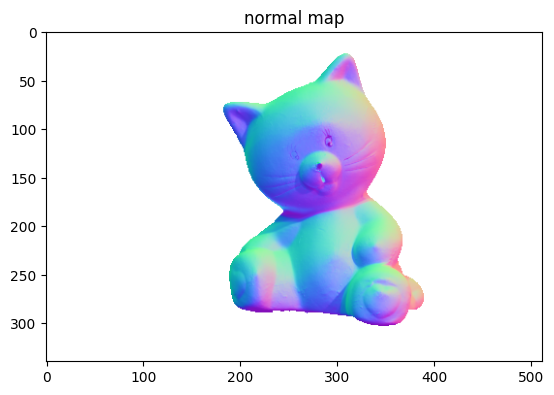

In [86]:
# TODO: save normal map as a RGB image and show it
print(N.shape)
N = (N + 1.0) / 2.0 
result = N + dst

plt.imshow(result)
plt.title('normal map')
plt.show()

## 3. Solving for color albedo

This gives a way to get the normal and albedo for one color channel. Once we have a normal $\mathbf{n}$ for each pixel, we can solve for the albedos by another least squares solution. The objective function is:

$$ Q = \Sigma_i{(I_i - k_d \mathbf{n}^\mathrm{T}\mathbf{L_i})^2} $$

To minimize it, differentiate with respect to $k_d$, and set to zero:

$$ \frac{\partial Q}{\partial k_d} = \Sigma_i{2(I_i - k_d \mathbf{n}^\mathrm{T}\mathbf{L_i})(\mathbf{n}^\mathrm{T}\mathbf{L_i})} = 0 $$

$$  k_d = \frac{\Sigma_i{I_i\mathbf{n}^\mathrm{T}\mathbf{L_i}}}{\Sigma_i{(\mathbf{n}^\mathrm{T}\mathbf{L_i})^2}} $$


Writing $J_i = \mathbf{L_i} \cdot \mathbf{n}$, we can also write this more concisely as a ratio of dot products: $k_d = \frac{\mathbf{I} \cdot \mathbf{J} } {\mathbf{J} \cdot \mathbf{J} }$. This can be done for each channel independently to obtain a per-channel albedo.

In [96]:
# TODO: calculate albedo

albedo = np.zeros(mask.shape)
vectors = np.zeros((12, 3))
images = []
for i in range(12):
    img = Image.open('./psmImages/cat/cat.'+ str(i) + '.bmp')
    img_ = np.array(img)
    images.append(img_)

for pos, val in np.ndenumerate(mask[:,:,2]):
    if val > 100:
        for idx, img in enumerate(images):
            vectors[idx] = img[pos[0]][pos[1]]
        
        J = np.dot(L, result[pos])
        k = np.dot(np.transpose(vectors), J) / (np.dot(J, J))
        if not np.isnan(np.sum(k)):
            albedo[pos] = k

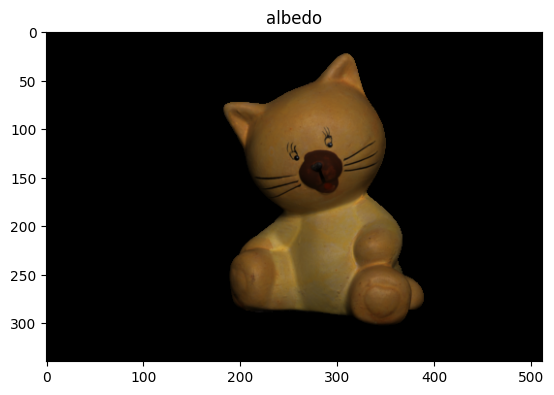

In [101]:
albedo = np.array(albedo, np.uint8)

plt.imshow(albedo)
plt.title('albedo')
plt.show()
# cv2.imshow('albedo', albedo)
# key = cv2.waitKey(0)
# while key == 27:
#     cv2.destroyAllWindows()
#     break

## 4. Least-squares surface fitting

Next we'll have to find a surface which has these normals, assuming such a surface exists. We will again use a least-squares technique to find the surface that best fits these normals. Here's one way of posing this problem as a least squares optimization.

If the normals are perpendicular to the surface, then they'll be perpendicular to any vector on the surface. We can construct vectors on the surface using the edges that will be formed by neighbouring pixels in the height map. Consider a pixel (i,j) and its neighbour to the right. They will have an edge with direction:

(i+1, j, z(i+1,j)) - (i, j, z(i,j)) = (1, 0, z(i+1,j) - z(i,j))

This vector is perpendicular to the normal n, which means its dot product with n will be zero:

(1, 0, z(i+1,j) - z(i,j)) . n = 0

$$ n_x + n_z(z(i+1,j) - z(i,j) = 0 $$

Similarly, in the vertical direction:

$$ n_y + n_z(z(i,j+1) - z(i,j) = 0 $$

We can construct similar constraints for all of the pixels which have neighbours, which gives us roughly twice as many constraints as unknowns (the z values). These can be written as the matrix equation Mz = v. The least squares solution solves the equation $\mathbf{M}^\mathrm{T}\mathbf{M}\mathbf{z}=\mathbf{M}^\mathrm{T}\mathbf{v}$. However, the matrix $\mathbf{M}^\mathrm{T}\mathbf{M}$ will still be really really big! It will have as many rows and columns as their are pixels in your image. Even for a small image of 100x100 pixels, the matrix will have 10^8 entries!

Fortunately, most of the entries are zero, and there are some clever ways of representing such matrices and solving linear systems with them. 

(a) most of the entries are zero, and there are some clever ways of representing such matrices called sparse matrices. You can figure out where those non-zero values are, put them in a sparse matrix, and then solve the linear system.

(b) there are iterative algorithms that allow you to solve linear system without explictly storing the matrix in memory, such as the conjugate gradient method:

import scipy

scipy.sparse.linalg.cg(A, b)

[Here](https://www.zhihu.com/question/388447602/answer/1200616778) is a blog using Python to solve the linear system.

(c) use SVD.

In [115]:
# TODO: solve for the z values for each pixel.
import scipy

def compute_depth(mask, N):
    im_h, im_w = mask.shape
    N = np.reshape(N, (im_h, im_w, 3))
    ##
    obj_h, obj_w = np.where(mask != 0)
    no_pix = np.size(obj_h) 
    full2obj = np.zeros((im_h, im_w))
    for idx in range(np.size(obj_h)):
        full2obj[obj_h[idx], obj_w[idx]] = idx

    M = scipy.sparse.lil_matrix((2*no_pix, no_pix))
    v = np.zeros((2*no_pix, 1))

    ##
    for idx in range(no_pix):
        h = obj_h[idx]
        w = obj_w[idx]
        n_x = N[h, w, 0]
        n_y = N[h, w, 1]
        n_z = N[h, w, 2]
        row_idx = idx * 2
        if mask[h, w+1]:
            idx_horiz = full2obj[h, w+1]
            M[row_idx, idx] = -1
            M[row_idx, idx_horiz] = 1
    #         if n_z==0:
    #             v[row_idx] = 0
    #         else:
    #             v[row_idx] = -n_x / n_z
    #     elif mask[h, w-1]:
    #         idx_horiz = full2obj[h, w-1]
    #         M[row_idx, idx_horiz] = -1
    #         M[row_idx, idx] = 1
    #         if n_z==0:
    #             v[row_idx] = 0
    #         else:
    #             v[row_idx] = -n_x / n_z
    #     row_idx = idx * 2 + 1
    #     if mask[h+1, w]:
    #         idx_vert = full2obj[h+1, w]
    #         M[row_idx, idx] = 1
    #         M[row_idx, idx_vert] = -1
    #         if n_z==0:
    #             v[row_idx] = 0
    #         else:
    #             v[row_idx] = -n_y / n_z
    #     elif mask[h-1, w]:
    #         idx_vert = full2obj[h-1, w]
    #         M[row_idx, idx_vert] = 1
    #         M[row_idx, idx] = -1
    #         if n_z==0:
    #             v[row_idx] = 0
    #         else:
    #             v[row_idx] = -n_y / n_z
    # MtM = M.T @ M
    # Mtv = M.T @ v
    # z = scipy.sparse.linalg.spsolve(MtM, Mtv)

    # std_z = np.std(z, ddof=1)
    # mean_z = np.mean(z)
    # z_zscore = (z - mean_z) / std_z
    # outlier_ind = np.abs(z_zscore) > 10
    # z_min = np.min(z[~outlier_ind])
    # z_max = np.max(z[~outlier_ind])

    # Z = mask.astype('float')
    # for idx in range(no_pix):
    #     h = obj_h[idx]
    #     w = obj_w[idx]
    #     Z[h, w] = (z[idx] - z_min) / (z_max - z_min) * 255
    # depth = Z
    # return depth
    

mask2 = cv2.imread('./psmImages/cat/cat.mask.bmp', 0)

##compute depth map
# Z = compute_depth(mask=mask2.copy(), N = normal.copy())
compute_depth(mask=mask2.copy(), N = normal.copy())

ValueError: Inexact indices into sparse matrices are not allowed

Plot the reconstructed 3D surface using 3D plot tool of matplotlib, see more information [here](https://matplotlib.org/3.1.0/gallery/mplot3d/surface3d.html).

In [ ]:
# TODO: plot the 3D surface
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# 补充内容：三维表面的其他表示方法 （选做）

光度立体技术适用于具有高低起伏的浅浮雕表面（bas-relief），这种三维表面体现了一种“纹理”，即在不同的光照角度下，表面的shading信息呈现“纹理”图像。这种纹理不是由表面的固有颜色信息表现的，而是由变化的表面高度在光照下形成的、随光照条件变化的纹理，我们称之为三维表面纹理（3D surface texture）。

三维表面纹理的建模除了光度立体方法之外，还可以使用其他手段。下面介绍一下五种低维表现方法，这些方法都能从多幅不同光照方向的图像中提取合用的表现数据。

- 3I：该方法使用三幅图像的线性组合生成其他光照角下的图像。
- Gradient: 即上文的光度立体方法，计算表面梯度和反照率。
- PTM: 多项式纹理映射(Polynomial Texture Maps, PTM)，将不同光照下的图像建模为光照向量分量的多项式。
- Eigen: 使用本征向量重构。

### 图像的矩阵表示方法

为了数据分析的简洁，通常把不同光照方向下的图像数据表示成一个矩阵，有利于进行分析和处理。

每个图像有m个像素，针对某个物体拍摄了n幅不同光照方向下的图像。把每幅图像拉成一个向量，然后把不同光照方向的图像向量组成一个矩阵。

用$i_{jk}$来表示第k幅图像中像素点j的亮度。

图像的二维坐标（x,y）用一维坐标表示为:$j = (x-1)*w+y$，w是图像的宽度。因此该物体的所有图像可以表示为一个mxn的矩阵：

$$I=\begin{bmatrix}
{i_{11}}&{i_{12}}&{\cdots}&{i_{1n}}\\
{i_{21}}&{i_{22}}&{\cdots}&{i_{2n}}\\
{\vdots}&{\vdots}&{\ddots}&{\vdots}\\
{i_{m1}}&{i_{m2}}&{\cdots}&{i_{mn}}\\
\end{bmatrix}
$$

在这个公式里面，每一列表示在某一特殊光照条件下一幅图像中的所有像素点亮度，而每一行则表示某一象素点在各种光照条件下的亮度。

我们将图像数据矩阵表示为两个矩阵乘积的形式，即$I=M_1M_2$

这么做的好处是为了数据表达上的方便，以及表达框架的统一。

$M_1$ is used to represent 3D surface property, and $M_2$ is used to represent lighting property. In the following discussions, we will assign different meanings and formulas for these two matrices.

如果知道了$M_2$，并且假定了某一反射和重光照模型，就可以求出$M_1$。Gradient方法和PTM方法都属于这一类。对于3I方法来说，$M_1$是原始图像数据矩阵$I$组成的。如果$M_2$未知或者我们不假定反射和重光照模型，则可以直接用SVD来分析图像数据矩阵$I$并且获取到$M_1$和$M_2$。后面将会提到基于Eigen的方法（Eigen3和Eigen6）就是这样做的。

重光照过程：表面表现数据矩阵$M_1$和特定光照条件向量$c$的乘积，即$i=M_1c$

$i$ 即为生成的图像数据向量，$i_1$,$i_2$,...,$i_m$ 表示其中的各个点的亮度值。

### Lambert model

在一个像素的位置上，朗伯反射公式表示为：$i(x,y)=λαn·l$

其中，i(x,y)表示坐标为（x,y）的像素点的亮度，λ是一个附加亮度信息，α是一个根据朗伯模型得到的反照率值，$n$是点（x,y）处的单位表面法向量，即
$n = (n_x,n_y,n_z)^T = (\frac{-p}{\sqrt[]{p^2+q^2+1}},\frac{-q}{\sqrt[]{p^2+q^2+1}},\frac{1}{\sqrt[]{p^2+q^2+1}})^T$

这其中 p 和 q 是表面高度图关于x和y的偏导数，即：

$p(x,y)=\frac{∂s(x,y)}{∂x}$ , $q(x,y)=\frac{∂s(x,y)}{∂y}$

s(x,y)是表面高度函数。

$l$是点（x,y）处的单位光照向量，即

$l = (l_x,l_y,l_z)^T = (cosτsinσ,sinτsinσ,cos σ)^T$

这里，σ是光源的翘角slant，τ是倾斜角tilt。

由于假设附加的亮度λ信息是一个常量，因此完全可以将它合并在反照率α。我们用ρ来表示这两个量的乘积，ρ=λα。

图像数据表示为 $I = ANL$

其中，$A$是表面的反照率矩阵
$$A=\begin{bmatrix}
 ρ_1&&&0\\
 &ρ_2&&\\
 &&\ddots&\\
 0&&&ρ_m\\
\end{bmatrix}$$
$N$是表面法向量矩阵
$$N=(n_1,n_2,...,n_m)^T=\begin{bmatrix}
 n_{1x}&n_{1y}&n_{1z}\\
 n_{2x}&n_{2y}&n_{2z}\\
 \vdots&\vdots&\vdots\\
 n_{mx}&n_{my}&n_{mz}\\
\end{bmatrix}
$$
$L$是光照矩阵
$$N=(l_1,l_2,...,l_m)=\begin{bmatrix}
 l_{1x}&l_{2x}&\cdots&l_{mx}\\
 l_{1y}&l_{2y}&\cdots&l_{my}\\
 l_{1z}&l_{2z}&\cdots&l_{mz}\\
\end{bmatrix}
$$

进一步定义一个新的矩阵$N_a$，$N_a=AN$

即$I = N_aL$

# gradient method

Gradient方法使用表面梯度和反照率图作为表面表现数据进行重光照。

根据朗伯模型定律，表面梯度和反照率图可以作为三维表面纹理的表现数据进行重光照，我们称这种方法为Gradient。3I使用三幅图像来建立符合朗伯模型的表面梯度和反照率图。过多的图导致系统成为一个过约束系统，无解，但是可以通过最小平方技术（比如SVD)来得到相对来说更加精确的解。

在$I=N_aL$中，$I$为一个mxn的矩阵，n为采用的图片数；$L$为光照矩阵，是一个已知的3xm的矩阵。

根据$I=N_aL$和$I=M_1M_2$得到，$M_1=N_a$且$M_2=L$

$N_a$包含了表面梯度和反照率信息，未知，且用SVD求解释非常繁琐。

因此，我们首先将光照矩阵分解：

$L=U_LW_L{V_L}^T$

即有：$N_a=IL^{-1}=IV_LW_L^{-1}U_L^T$

对$N_a$光照，就可以得到任意光照条件下的新图像：

$i=N_al$

Gradient方法就是我们上面实现的光度立体方法，能够得到表面的法向量。因此属于三维重建范畴。

### 3I method

3I方法由三幅光度学图像线性合并生成新的图像。

Shashua的研究发现，表面凸凹不平的物体图像的表现可以由满足朗伯反射模型假设的三幅图像进行线性合成得到。我们称这种方法为3I。

这三幅图像是分别在光源位置不同的情况下得到的。这三幅图像称为“光度测定图”。这样，根据$i=M_1c$，我们只需要决定包含线性合成系数的向量c就可以了。根据$I = N_aL$，并计算好反向光照矩阵即可。

我们得到了三个非相关的光照向量，光照矩阵可以这样表达
$$L=(l_1,l_2,l_3)=\begin{bmatrix}
l_{1x}&l_{2x}&l_{3x}\\
l_{1y}&l_{2y}&l_{3y}\\
l_{1z}&l_{2z}&l_{3z}\\
\end{bmatrix}$$

同样，三幅图像的图像数据矩阵为 
$$I=\begin{bmatrix} 
l_{11}&l_{12}&l_{13}\\
l_{21}&l_{22}&l_{23}\\
\vdots&\vdots&\vdots \\
l_{m1}&l_{m2}&l_{m3}\\
\end{bmatrix}$$

则 $N_a=IL^{-1}$

重光照：任意给定光照方向可得到相应的光照向量$\vec{l} = (l_x,l_y,l_z)^T = (\cos\tau\sin\sigma,\sin\tau\sin\sigma,\cos\sigma)^T$，其中$\sigma$为

即可得到生成的图像的个像素点亮度，表示为：$i=IL^{-1}l$


而根据$i=M_1c$，我们又可以得到$c=L^{-1}l$,

即$i=M_1c=Ic$

我们就可以得到结论：给定光照方向生成的新的图像是由三幅已知图像线性组合得到的，其中的$c$称为系数向量。


In [ ]:
# TODO: implement the 3I method

# PTM method

PTM方法使用多项式纹理映射作为表面纹理表示方式。Malzbender等人提出了一种亮度表示模型, 用两度向量的二次多项式来表示因自己产生的阴影和反射导致的复杂纹理表示形式。它也是基于朗伯模型的假设，并且使用了单位光照向量的前两项来组成了一个新的六维向量，即

$l_{ptm}=(l_x^2,l_y^2,l_xl_y,l_x,l_y,1)^T=(cosτ^2sinσ^2,sinτ^2sinσ^2,cosτsinτsinσ^2，cosτsinσ，sinτsinσ，1)^T$

则图像数据为$I=A_{ptm}L_{ptm}$

其中，$A_{ptm}$为PTM矩阵，矩阵的每一行表示在每个像素位置处根据亮度模型的六个系数，$L_{ptm}$为光照矩阵，分别等价于$M_1$和$M_2$

$$A_{ptm}=\begin{bmatrix}
 a_{11}&a_{12}&a_{13}&a_{14}&a_{15}&a_{16}\\
 a_{21}&a_{22}&a_{23}&a_{24}&a_{25}&a_{26}\\
 \vdots&\vdots&\vdots&\vdots&\vdots&\vdots\\
 a_{m1}&a_{m2}&a_{m3}&a_{m4}&a_{m5}&a_{m6}\\
\end{bmatrix}
$$

$$L_{ptm}=\begin{bmatrix}
 1&1&\cdots&1\\
 l_{y1}&l_{y2}&\cdots&l_{yn}\\
 l_{x1}&l_{x2}&\cdots&l_{xn}\\
 l_{x1}l_{y1}&l_{x2}l_{y2}&\cdots&l_{xn}l_{yn}\\
 l_{y1}^2&l_{y2}^2&\cdots&l_{yn}^2\\
 l_{x1}^2&l_{x2}^2&\cdots&l_{xn}^2
\end{bmatrix}
$$


$I$和$L_{PTM}$都已知，可以使用SVD来求解得到$A_{PTM}$

重光照，新生成的图像为：

$i=M_1c=A_{ptm}L_{PTM}$

In [ ]:
# TODO: implement the PTM method

### Eigen method

Eigen模型是许多研究人员使用的一种特殊的处理各种光照的模型。这些方法的优势在于不需要任何表面反射模型的假设。Epstein等人在实验的基础上提出了一种有效的使用五幅图像为基础来合成任意光照条件下的物体纹理。他们的断定这项研究成果可以在物体有光滑顶部、光滑的尖起、微弱的阴影的情况下，模拟朗伯表面模型。当然，由于镜面反射和复杂的表面几何形状都增加了所需的图像数目。

Eigen3算法在Eigen空间上采用三幅图象，Eigen6算法在Eigen空间上采用6幅图象的来重建三维表面纹理。Eigen3可以实现符合朗伯模型的三维表面纹理合成，而Eigen6则可以实现带有特定镜面反射和阴影的表面纹理的合成。应用SVD来生成Eigen空间下的数据，图像的数据矩阵表示形式为:

$I=U_IW_IV_I^T$

其中矩阵$U_I$中的每一列即是矩阵$W_I$的奇异值相应的Eigen向量。$U_I$用来构建基于Eigen的图像，而$V_I^T$包含了线性合成时用到的系数。

将$W_I$表示成$W_I=diag(w_1,w_2,...,w_n)$

矩阵$W_I$的一个重要的属性就是其奇异值非常少。前面的几个特征向量就已占据了整个图像数据矩阵I中超过99%的信息。因此将$W_I$近似为

$\hat{W_I}=diag(w_1,w_2,...,w_k,0,...,0)$
其中k是希望保留的特征值的个数。

然后我们就得到了一个近似的图像数据矩阵$I$,为$\hat{I}=U_I\hat{W_I}V_I^T$

由于$I=M_1M_2$,

我们得到$M_1=U_I\hat{W_I}$, $M_2=V_I^T$

重新令$M_1$是mxk的矩阵，其中$U_I\hat{W_I}$后面的n-k列全部为0。

类似的，我们重写$M_2$是kxn的矩阵，里面只保留了$V_I^T$中的前k行数据，因为\hat{W_I}的后面n-k列全部为0。

通过如此操作，我们得到了在特征向量空间的一系列的k-基图像数据，这些图像称之为Eigen base image。使用3幅Eigen base image作为表现数据时，就是Eigen 3, 6幅为Eigen 6。矩阵$M_2$提供了根据这些Eigen base image图像得到原始图像$I$数据之间的线性合成系数。

因此，$I=(i_1,i_2,...,i_m)=M_1M_2$

In [ ]:
# TODO: implement the eigen method